<a href="https://colab.research.google.com/github/Seevakan1997/Fake-News-Detection/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, subprocess, pkg_resources

required = {
    "pandas", "numpy", "nltk", "scikit-learn",
    "matplotlib", "seaborn", "wordcloud", "tqdm", "joblib"
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:



    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])

/tmp/ipython-input-11100952.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, subprocess, pkg_resources


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, auc
)
from wordcloud import WordCloud
import joblib
import os

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
true_path = "data/True.csv"
fake_path = "data/Fake.csv"

if not os.path.exists(true_path) or not os.path.exists(fake_path):
    raise FileNotFoundError("Place True.csv and Fake.csv inside the data/ folder")

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

true_df["label"] = "real"
fake_df["label"] = "fake"

df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
print("Dataset shape:", df.shape)
print(df["label"].value_counts())

Dataset shape: (44898, 5)
label
fake    23481
real    21417
Name: count, dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
print("Total samples:", len(df))
print("\nClass distribution:")
print(df["label"].value_counts())
print("\nClass distribution (%):")
print(df["label"].value_counts(normalize=True) * 100)

Total samples: 44898

Class distribution:
label
fake    23481
real    21417
Name: count, dtype: int64

Class distribution (%):
label
fake    52.298543
real    47.701457
Name: proportion, dtype: float64


In [8]:
df["char_length"] = df["text"].astype(str).apply(len)

df.groupby("label")["char_length"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,23481.0,2547.396235,2532.884399,1.0,1433.0,2166.0,3032.0,51794.0
real,21417.0,2383.278517,1684.835730,1.0,914.0,2222.0,3237.0,29781.0


In [ ]:
df["text"] = df["title"].astype(str) + " " + df["text"].astype(str)

In [ ]:
print("\nExample rows:")
print(df.head())


Example rows:
                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...          News   
1   Failed GOP Candidates Remembered In Hilarious...          News   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...          News   
3  California AG pledges to defend birth control ...  politicsNews   
4  AZ RANCHERS Living On US-Mexico Border Destroy...      politics   

               date label  
0     July 21, 2017  fake  
1       May 7, 2016  fake  
2  December 3, 2016  fake  
3  October 6, 2017   real  
4      Apr 25, 2017  fake  


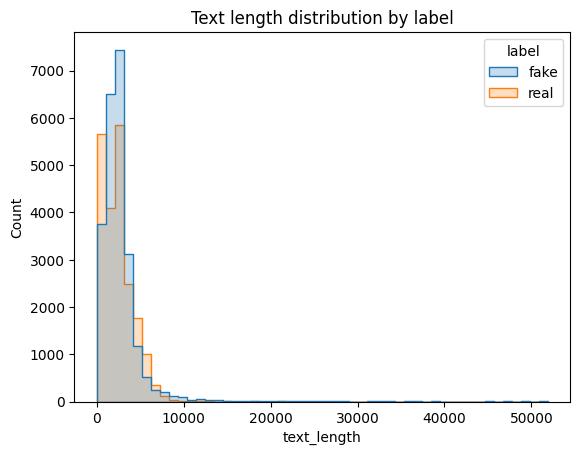

In [ ]:
df["text_length"] = df["text"].apply(len)
sns.histplot(df, x="text_length", hue="label", element="step", bins=50)
plt.title("Text length distribution by label")
plt.show()

In [ ]:
fake_text = " ".join(df[df.label == "fake"]["text"].tolist())
real_text = " ".join(df[df.label == "real"]["text"].tolist())

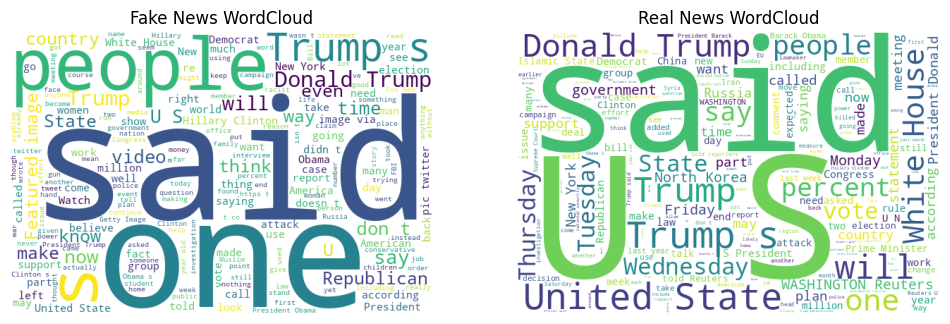

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color="white").generate(fake_text))
plt.title("Fake News WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color="white").generate(real_text))
plt.title("Real News WordCloud")
plt.axis("off")
plt.show()

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    tokens = nltk.word_tokenize(text)
    clean_tokens = []
    for token in tokens:
        if token.isalpha() and token not in stop_words:
            token = lemmatizer.lemmatize(token)
            clean_tokens.append(token)
    return " ".join(clean_tokens)

tqdm.pandas()
df["clean_text"] = df["text"].progress_apply(preprocess_text)
print("Preprocessing complete.")
print(df[["text", "clean_text"]].head())

100%|██████████| 44898/44898 [02:43<00:00, 275.14it/s]

Preprocessing complete.
                                                text  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                          clean_text  
0  breaking gop chairman grassley enough demand t...  
1  failed gop candidate remembered hilarious mock...  
2  mike penny new dc neighbor hilariously trollin...  
3  california ag pledge defend birth control insu...  
4  az rancher living border destroy nancy pelosi ...  


In [ ]:
X = df["clean_text"].values
y = df["label"].map({"fake":0, "real":1}).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 35918 Test size: 8980


In [ ]:
fake_keywords = {"hoax", "false", "untrue", "fake", "rumor", "claim", "fabricated", "misleading"}
real_keywords = {"report", "official", "statement", "confirmed", "said", "announced"}

def rule_based_predict(text):
    tokens = set(text.split())
    score = 0
    for t in tokens:
        if t in real_keywords:
            score += 1
        if t in fake_keywords:
            score -= 1
    return 1 if score > 0 else 0

y_pred_rule = [rule_based_predict(t) for t in X_test]
print("\nRule-Based Model Evaluation:")
print(classification_report(y_test, y_pred_rule, target_names=["Fake","Real"]))


Rule-Based Model Evaluation:
              precision    recall  f1-score   support

        Fake       0.87      0.42      0.57      4696
        Real       0.59      0.93      0.73      4284

    accuracy                           0.66      8980
   macro avg       0.73      0.68      0.65      8980
weighted avg       0.74      0.66      0.64      8980



In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF matrix shape:", X_train_tfidf.shape)

TF-IDF matrix shape: (35918, 10000)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    try:
        y_score = model.decision_function(X_test_tfidf)
        roc = roc_auc_score(y_test, y_score)
    except:
        try:
            y_score = model.predict_proba(X_test_tfidf)[:,1]
            roc = roc_auc_score(y_test, y_score)
        except:
            roc = None
    results[name] = [acc, prec, rec, f1, roc]
    print(f"{name}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, ROC={roc}")


Training Logistic Regression...
Logistic Regression: Acc=0.988, Prec=0.984, Rec=0.991, F1=0.988, ROC=0.9989542523426179

Training Naive Bayes...
Naive Bayes: Acc=0.947, Prec=0.942, Rec=0.947, F1=0.944, ROC=0.9861479941209874

Training SVM...
SVM: Acc=0.996, Prec=0.995, Rec=0.996, F1=0.995, ROC=0.9997983364271319

Training Random Forest...
Random Forest: Acc=0.997, Prec=0.995, Rec=0.998, F1=0.996, ROC=0.9998735439661385



Model Performance Summary:
                     Accuracy  Precision    Recall        F1   ROC_AUC
Logistic Regression  0.988085   0.984009  0.991130  0.987557  0.998954
Naive Bayes          0.946659   0.941928  0.946545  0.944231  0.986148
SVM                  0.995657   0.995101  0.995798  0.995450  0.999798
Random Forest        0.996548   0.994880  0.997899  0.996387  0.999874


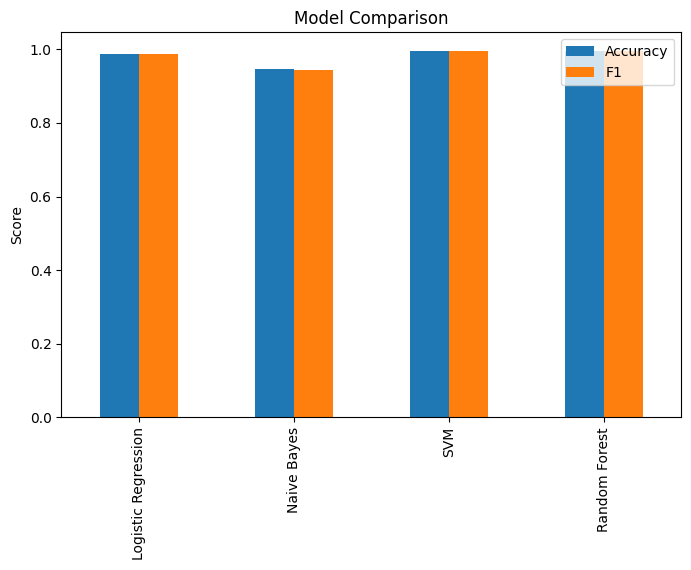


Best model by F1: Random Forest


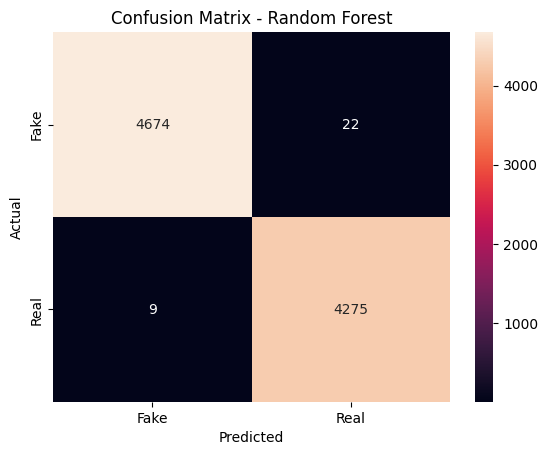

In [ ]:
results_df = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1","ROC_AUC"]).T
print("\nModel Performance Summary:")
print(results_df)

# Plot comparison
results_df[["Accuracy","F1"]].plot(kind="bar", figsize=(8,5))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.show()

# Confusion Matrix for Best Model
best_model_name = results_df["F1"].idxmax()
print(f"\nBest model by F1: {best_model_name}")
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

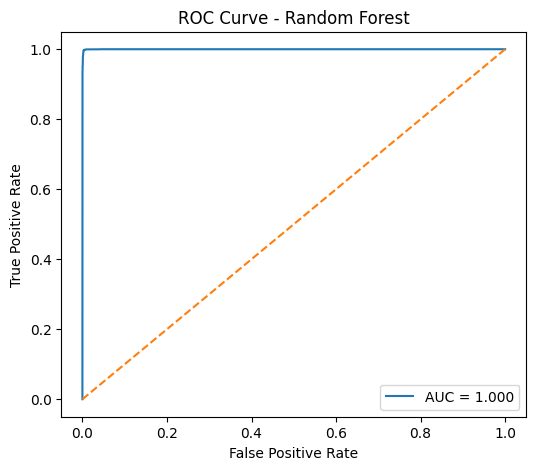

In [ ]:
try:
    y_score = best_model.decision_function(X_test_tfidf)
except:
    y_score = best_model.predict_proba(X_test_tfidf)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_model_name}")
plt.legend()
plt.show()

In [ ]:
os.makedirs("saved_models", exist_ok=True)
joblib.dump(vectorizer, "saved_models/tfidf_vectorizer.joblib")
joblib.dump(best_model, f"saved_models/{best_model_name.replace(' ','_')}.joblib")
print("Model saved in ./saved_models/")

Model saved in ./saved_models/


In [ ]:
def predict_text(text):
    cleaned = preprocess_text(text)
    vec = vectorizer.transform([cleaned])
    pred = best_model.predict(vec)[0]
    label = "Real" if pred == 1 else "Fake"
    print(f"\nText: {text}\nPredicted: {label}")

predict_text("Breaking news: NASA confirms water found on Mars surface.")
predict_text("Celebrity claims aliens control world politics!")


Text: Breaking news: NASA confirms water found on Mars surface.
Predicted: Fake

Text: Celebrity claims aliens control world politics!
Predicted: Fake


In [ ]:
print("\nReflection:")
print("""
- Rule-based model was simple but weak due to limited keyword coverage.
- TF-IDF with classical ML models performed well; Logistic Regression and SVM often excel.
- Data preprocessing (stopwords, lemmatization) improved text clarity and reduced noise.
- Limitations: dataset imbalance, handcrafted preprocessing, lack of contextual understanding.
- Future work: fine-tune transformer models (BERT), add metadata (subject, source), use cross-validation and hyperparameter tuning.
""")


Reflection:

- Rule-based model was simple but weak due to limited keyword coverage.
- TF-IDF with classical ML models performed well; Logistic Regression and SVM often excel.
- Data preprocessing (stopwords, lemmatization) improved text clarity and reduced noise.
- Limitations: dataset imbalance, handcrafted preprocessing, lack of contextual understanding.
- Future work: fine-tune transformer models (BERT), add metadata (subject, source), use cross-validation and hyperparameter tuning.

